In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Questions to ask: <b>
* How biased is ratemyprofessor compared to FCE?
* undergraduate vs graduate

In [8]:
df = pd.read_csv("fce.csv")
df.head()

,Year,Semester,College,Dept,Course ID,Section,Name,Course Name,Level,Possible Respondents,...,Hrs Per Week 8,Interest in student learning,Clearly explain course requirements,Clear learning objectives & goals,Instructor provides feedback to students to improve,Demonstrate importance of subject matter,Explains subject matter of course,Show respect for all students,Overall teaching rate,Overall course rate
0,2019,Fall,College of Fine Arts,ARC,48358,B1,"BEN-ALON, RACHEL",EARTHEN BUILDING,Undergraduate,26,...,NaN,4.79,4.62,4.57,4.69,4.57,4.71,4.93,4.71,4.71
1,2019,Fall,College of Fine Arts,ARC,48358,A1,"BEN-ALON, RACHEL",EARTHEN BUILDING,Undergraduate,8,...,NaN,5.00,5.00,4.83,4.83,5.00,4.83,5.00,4.33,4.17
2,2019,Fall,College of Fine Arts,ARC,48689,A1,"KIM, MAN",DIGI SKLLS WRKSHP,Graduate,14,...,NaN,4.75,4.63,4.75,4.88,4.50,4.75,4.63,4.75,4.38
3,2019,Fall,College of Fine Arts,ARC,48753,A1,"DAWKINS, MARANTHA",INTRO UD MED,Graduate,14,...,NaN,4.00,3.00,3.60,4.40,3.60,3.40,4.60,3.60,3.20
4,2019,Fall,College of Fine Arts,ART,60131,A1,"GURYSH, STEVEN",3D MEDIA STUDIO I,Undergraduate,11,...,NaN,4.88,4.63,4.86,4.86,4.57,4.86,5.00,4.86,4.71


First let us clean the data by checking the NaN values of each column as shown below. There also seem to be one "Name" row with a NaN that seem to be an outlier, so let's drop this row. There also seem to be a lot of NaN values for Hrs Per Week 5 and Hrs Per Week 8, so let's drop these two columns and replace the other column with NaN values with the mean.

In [6]:
print(df.isna().sum())

Year                                                       0
Semester                                                   0
College                                                    0
Dept                                                       0
Course ID                                                  0
Section                                                    0
Name                                                       1
Course Name                                                0
Level                                                      0
Possible Respondents                                       0
Num Respondents                                            0
Response Rate %                                            0
Hrs Per Week                                           20635
Hrs Per Week 5                                         37504
Hrs Per Week 8                                         42744
Interest in student learning                            1661
Clearly explain course r

In [89]:
df = df[pd.notnull(df['Name'])]
df = df[df["College"] != "Teaching Assistants"]
if "Hrs Per Week 5" in df.columns and "Hrs Per Week 8" in df.columns:
    df = df.drop(columns=["Hrs Per Week 5", "Hrs Per Week 8"])

In [90]:
df.dtypes

Year                                                     int64
Semester                                                object
College                                                 object
Dept                                                    object
Course ID                                               object
Section                                                 object
Name                                                    object
Course Name                                             object
Level                                                   object
Possible Respondents                                     int64
Num Respondents                                          int64
Response Rate %                                          int64
Hrs Per Week                                           float64
Interest in student learning                           float64
Clearly explain course requirements                    float64
Clear learning objectives & goals                      

In [91]:
lst = df.columns[df.isnull().any()].tolist()
df[lst] = df[lst].fillna(df[lst].mean())
print(df.isna().sum())

Year                                                   0
Semester                                               0
College                                                0
Dept                                                   0
Course ID                                              0
Section                                                0
Name                                                   0
Course Name                                            0
Level                                                  0
Possible Respondents                                   0
Num Respondents                                        0
Response Rate %                                        0
Hrs Per Week                                           0
Interest in student learning                           0
Clearly explain course requirements                    0
Clear learning objectives & goals                      0
Instructor provides feedback to students to improve    0
Demonstrate importance of subje

Now that we have cleaned up the data, let's ask some small questions about this dataset.
* How is the average FCE per college for Graduate and Undergraduate?
* Which column is most correlated to the Overall course rate?

In [92]:
df_grad = df[df['Level'] == "Graduate"]
df_undergrad = df[df['Level'] == "Undergraduate"]
print(len(df_grad), len(df_undergrad))

20070 29465


In [93]:
avg_grad_fce = df_grad.groupby(["Year", "College"], as_index=False).mean()
avg_undergrad_fce = df_undergrad.groupby(["Year", "College"], as_index=False).mean()

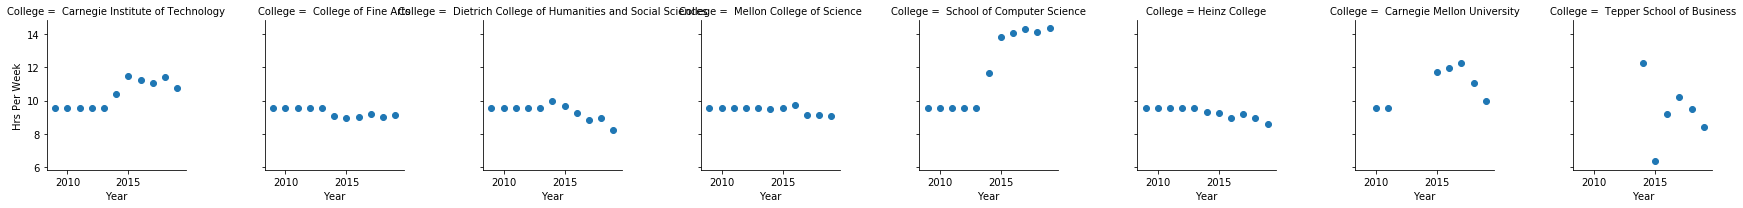

In [94]:
avg_grad_fce = avg_grad_fce.groupby(["Year", "College"], as_index=False).mean()
avg_grad_fce = avg_grad_fce[["Year", "College","Hrs Per Week"]]

g = sns.FacetGrid(avg_grad_fce, col="College")
g.map(plt.scatter, "Year", "Hrs Per Week")
g.add_legend()

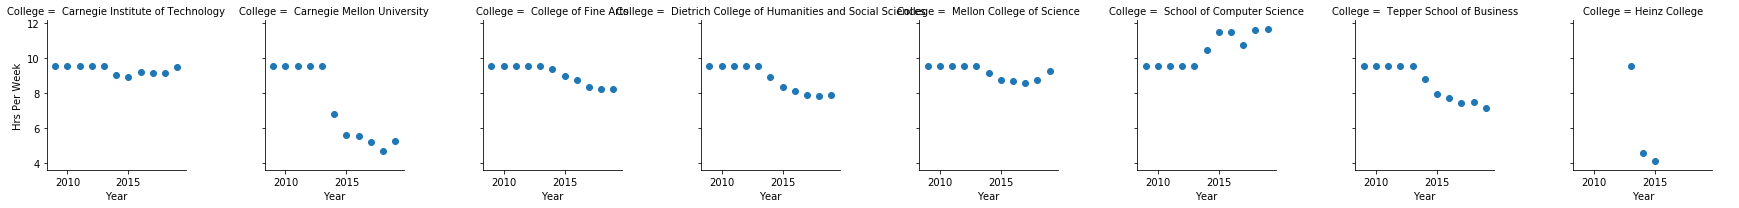

In [115]:
avg_undergrad_fce = avg_undergrad_fce.groupby(["Year", "College"], as_index=False).mean()
avg_undergrad_fce = avg_undergrad_fce[["Year", "College","Hrs Per Week"]]

g = sns.FacetGrid(avg_undergrad_fce, col="College")
g.map(plt.scatter, "Year", "Hrs Per Week")
g.add_legend()

We can find some interesting results based on the graphs above. 
* For graduates at CMU, the FCE seem to be having an increasing trend over the years, peaking around 2017, and then gradually decrease till now. Whereas for the undergrads at CMU, the FCE seem to be decreasing, with a slight increase at 2019. 
* The School of Computer Science has the greatest increase, with an approximately 5 hours of increase from 2013 to 2019 for the graduates(9hr -> 14hr), and approximately 3 hours of increase from (9hr -> 12hr) <br>
Cite: this dataset is also used in CMU Data Science Club's Challenges, so this part (FCE by college) might appear similar. <br>
Now let's do some analysis on the correlation of the columns.

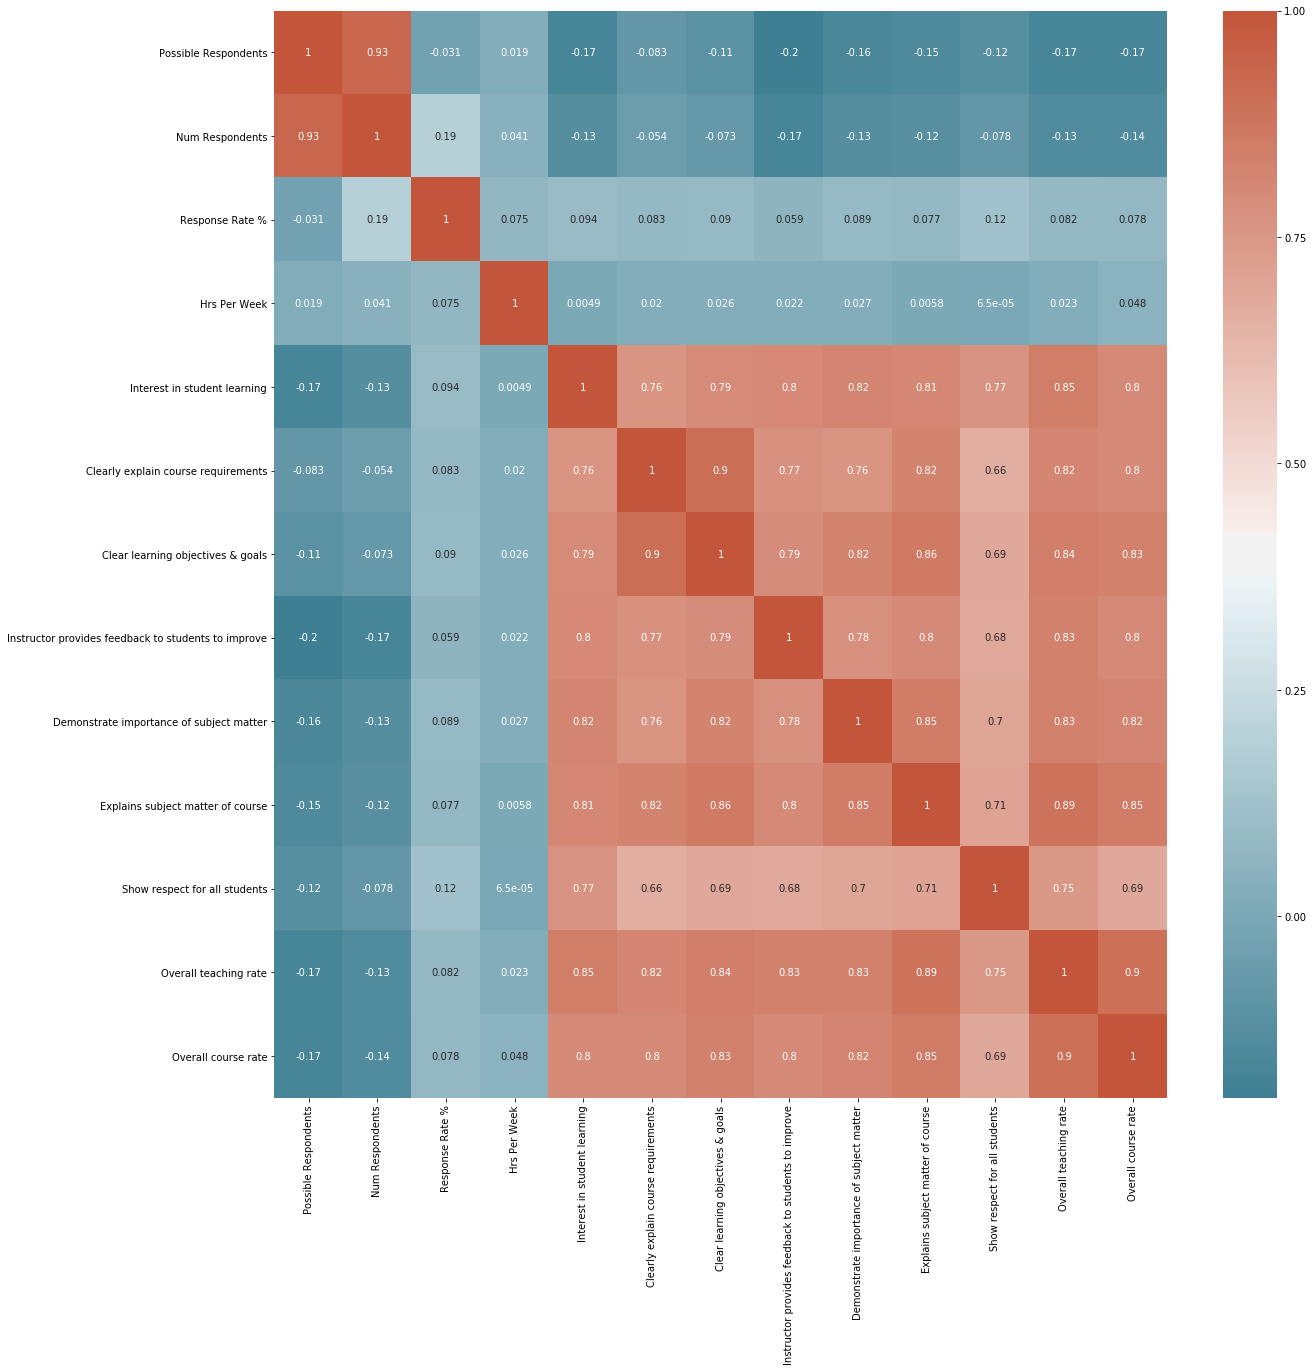

In [128]:
# sns.palplot(sns.color_palette("BrBG", 10))
plt.figure(figsize = (20,20))
corr_lst = list(df.select_dtypes(include=['int', 'float']).columns)
corr_df = df[corr_lst]
corr_df.drop("Year", axis=1, inplace=True)
corr = corr_df.corr()
# ax = sns.heatmap(corr, cmap="YlGnBu",annot=True)
ax = sns.heatmap(corr, cmap=sns.diverging_palette(220, 20, as_cmap=True),annot=True)

It seems that the `overall teaching rate` is highly correlated with `overall course rate` and `Explains subject matter of course`.